# EXPERIMENT ON STARTEGIES ON THE DAILY TIMEFRAME


In [58]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
import yfinance as yf


In [5]:
# Define ticker symbols
es_ticker = "^GSPC"  # S&P 500 as a proxy for ES futures
dxy_ticker = "DX-Y.NYB"
vix_ticker = "^VIX"

full_daterange = pd.date_range('2000-01-01', '2024-04-20', freq='D')
train_daterange = pd.date_range('2000-01-01', '2020-12-31', freq='D')
test_daterange = pd.date_range('2021-01-01', '2024-04-30', freq='D')

df_es = yf.download(es_ticker)
df_dxy = yf.download(dxy_ticker)
df_vix = yf.download(vix_ticker)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
def clean_data(_data : pd.DataFrame, keep_volume=False, compute_target=False, look_forward=15, upper_factor=3, lower_factor=3):
    data = _data.copy()
    data.columns = data.columns.str.lower()

    columns = ['atr', 'returns']

    data.loc[:, 'returns'] = data['close'].pct_change(fill_method=None).fillna(0)

    data['_atr'] = ta.atr(data['high'], data['low'], data['close'], length=5)
    rolling_mean = data['_atr'].rolling(window=5).mean()
    rolling_std = data['_atr'].rolling(window=5).std()
    data.loc[:, 'atr'] = (data['_atr'] - rolling_mean) / rolling_std

    

    if keep_volume:
        data.loc[:, 'volume_change'] = data['volume'].pct_change(fill_method=None)
        columns.append('volume_change')

    data = data.dropna()

    if compute_target:
        columns.append('target')
        labels = []
        results = []
    
        for i in range(len(data)):
            price = data['close'].iloc[i]
            _atr = data['_atr'].iloc[i]
            upper_barrier = price + (_atr * upper_factor)
            lower_barrier = price - (_atr * lower_factor)
            
            forward_prices = data['close'].iloc[i+1:i+1+look_forward]
            
            upper_cross = forward_prices[forward_prices >= upper_barrier]
            lower_cross = forward_prices[forward_prices <= lower_barrier]
            
            if not upper_cross.empty and not lower_cross.empty:
                label = 1 if upper_cross.index[0] < lower_cross.index[0] else -1
            elif not upper_cross.empty:
                label = 1
            elif not lower_cross.empty:
                label = -1
            else:
                label = 0  # No barrier touched
            
            labels.append(label)

        data['target'] = labels


    data = data.dropna()
    data = data[data.index.isin(full_daterange)]
        

    return data[columns]

clean_df_es = clean_data(df_es, True, True)
clean_df_vix = clean_data(df_vix)
clean_df_dxy = clean_data(df_dxy)

full_df = clean_df_es.join([clean_df_dxy.add_prefix('dxy_'), clean_df_vix.add_prefix('vix_')], how='inner')

In [65]:
from sklearn.cluster import KMeans

np.random.seed(0)

n_cluster = 24 
kmeans = KMeans(n_clusters=n_cluster)


X = full_df.drop('target', axis=1)

split_index = round(len(X) * .7)
X_train, X_test = X[:split_index], X[split_index:]


# Fitting the model with the data
kmeans.fit(X_train)

# Predicting the cluster labels for the X=
labels = kmeans.predict(X)
full_df['labels'] = labels

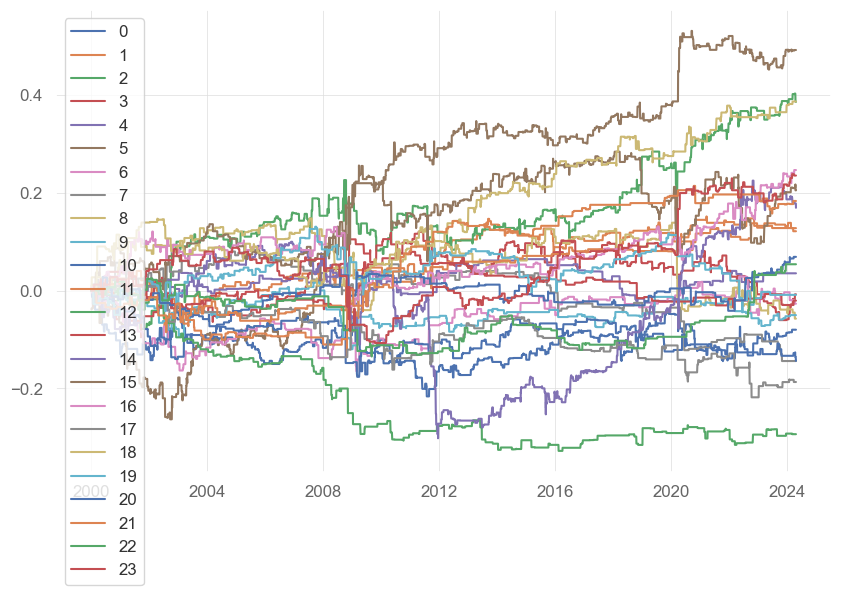

In [63]:
import quantstats as qt

for label in range(n_cluster):
    signal = full_df['labels'] == label
    signal = signal.astype(int)
    
    _ret = signal * full_df['returns'].shift(-1)
    plt.plot(np.cumsum(_ret), label=label)

plt.legend()
